# VKLIKE TF2 (EfficientNet)

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/DATA/20220424-vklike_dataset.zip /content
!unzip -qq -d /content /content/20220424-vklike_dataset.zip
!ls /content

20220424-vklike_dataset  20220424-vklike_dataset.zip  gdrive  sample_data


In [3]:
!ls /content/20220424-vklike_dataset

dislike  like  lobe-bf07e5dd7a5d4a398e09d19ce4215f74.csv


In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [46]:
VALIDATION_SPLIT = 0.2
SEED = 13370
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

DATA = '/content/20220424-vklike_dataset'

# Keras will automatically create labels (0 - dislike, 1 - like)

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "training",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

validation_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "validation",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 8444 files belonging to 2 classes.
Using 6756 files for training.
Found 8444 files belonging to 2 classes.
Using 1688 files for validation.


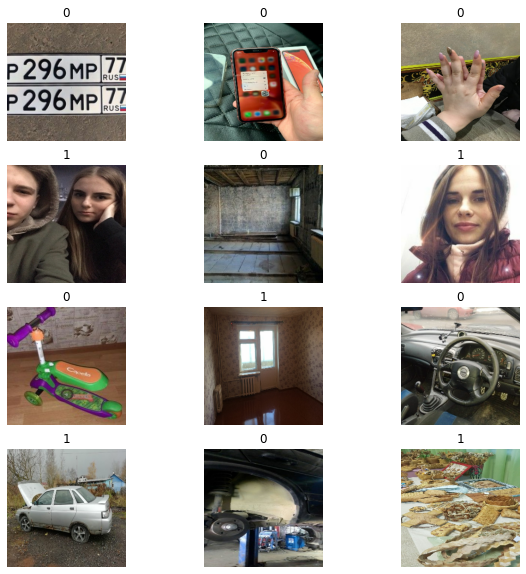

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [49]:
# Create augmentaion layer for model
img_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    # tf.keras.layers.RandomContrast(0.1, seed=42),
])

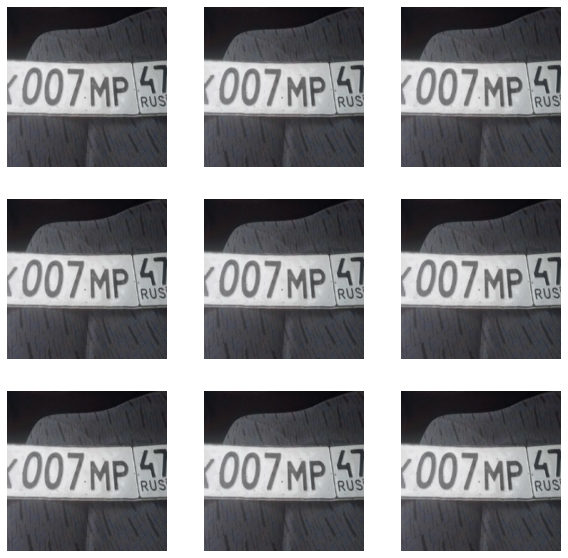

In [50]:
# Let see how augmentaion works
plt.figure(figsize=(10, 10))
for images, _ in training_images.take(1):
    for i in range(9):
        augmented_images = img_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [51]:
# Prepare inputs
# prefetch may in some situation improve performance
training_images = training_images.prefetch(buffer_size=32)
validation_images = validation_images.prefetch(buffer_size=32)

In [54]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    cnn = tf.keras.applications.EfficientNetB0(
        input_tensor=x,
        include_top=False,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="EfficientNet")

In [55]:
# Create an instance of model
model = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0.5,
)

16719872/16705208 [==============================] - 0s 0us/step


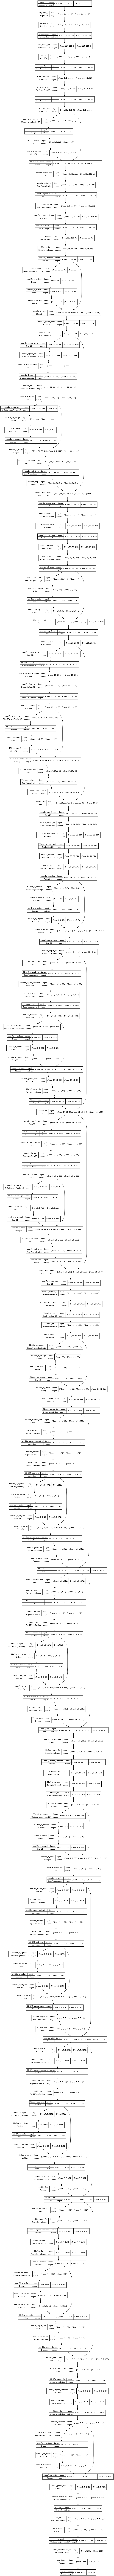

In [56]:
# Визуализируем её.
tf.keras.utils.plot_model(model, show_shapes = True)

In [58]:
# We will save weight of model after each epoch of training in Keras (h5) format.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("vklike_model/epoch_{epoch}.h5")
]

# We unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # for training head layer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # for training last 20 layers

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [59]:
EPOCHS = 10

history = model.fit(
    training_images, epochs=EPOCHS, callbacks=callbacks, validation_data=validation_images
)

Epoch 1/10
212/212 [==============================] - 55s 205ms/step - loss: 0.4905 - accuracy: 0.7913 - val_loss: 0.2779 - val_accuracy: 0.8880
Epoch 2/10
212/212 [==============================] - 43s 199ms/step - loss: 0.3557 - accuracy: 0.8564 - val_loss: 0.2557 - val_accuracy: 0.8963
Epoch 3/10
212/212 [==============================] - 42s 193ms/step - loss: 0.3192 - accuracy: 0.8731 - val_loss: 0.2478 - val_accuracy: 0.8993
Epoch 4/10
212/212 [==============================] - 42s 192ms/step - loss: 0.2830 - accuracy: 0.8847 - val_loss: 0.2487 - val_accuracy: 0.9005
Epoch 5/10
212/212 [==============================] - 42s 192ms/step - loss: 0.2570 - accuracy: 0.8951 - val_loss: 0.2491 - val_accuracy: 0.8981
Epoch 6/10
212/212 [==============================] - 42s 192ms/step - loss: 0.2370 - accuracy: 0.9047 - val_loss: 0.2455 - val_accuracy: 0.8999
Epoch 7/10
212/212 [==============================] - 42s 192ms/step - loss: 0.2230 - accuracy: 0.9093 - val_loss: 0.2468 - val_ac

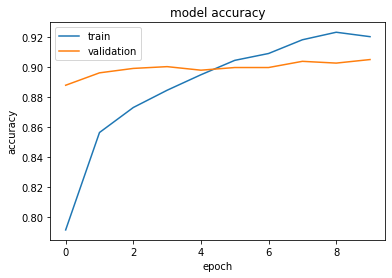

In [60]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [23]:
# Сохраняем модель целиком в формате TensorFlow (saved_model.pb + variables/).
model.save("vklike_model")

INFO:tensorflow:Assets written to: vklike_model/assets


In [ ]:
# Либо загружаем весовые коэффециенты от заранее обученной модели в формате Keras (h5).
model.load_weights('vklike_model/epoch_48.h5')

In [ ]:
# Либо загружаем заранее обученную модель целиком из формата TensorFlow (saved_model.pb + variables/).
model = tf.keras.models.load_model("vklike_model")

Image is LIKE with 0.9940176010131836 confidence


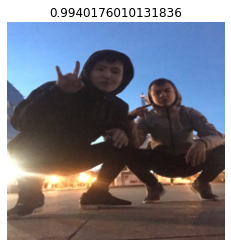

In [61]:
import requests
from PIL import Image

url = 'https://sun9-77.userapi.com/impg/Xv8dJh4OnSgY2ZAc04-_L7SokiJCxmwDKv2PrQ/_htEJkgpA0M.jpg?size=811x1080&quality=96&sign=1641ab517a74fa2e23ef2b0d2acf9ecf&c_uniq_tag=xhbHQL3zHtK59Dfuyz47cQPIIrBtDgIkP_VVRCPXoR0&type=album'
res = requests.get(url, stream=True)
# img = tf.keras.preprocessing.image.load_img(
#     "<path_to_image>", target_size=IMAGE_SIZE
# )
img = Image.open(res.raw)
img = img.resize(IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0][0]
plt.imshow(img)
plt.title(f"{score}")
plt.axis("off")

print(
    f"Image is LIKE with {score} confidence"
)